In [2]:
library(CDMConnector)
library(CodelistGenerator)
library(CohortConstructor)
library(CohortCharacteristics)
library(IncidencePrevalence)
library(DrugExposureDiagnostics)
library(CohortSurvival)
library(TreatmentPatterns)

In [3]:
example_datasets()

[1] "GiBleed"                             "synthea-allergies-10k"              
 [3] "synthea-anemia-10k"                  "synthea-breast_cancer-10k"          
 [5] "synthea-contraceptives-10k"          "synthea-covid19-10k"                
 [7] "synthea-covid19-200k"                "synthea-dermatitis-10k"             
 [9] "synthea-heart-10k"                   "synthea-hiv-10k"                    
[11] "synthea-lung_cancer-10k"             "synthea-medications-10k"            
[13] "synthea-metabolic_syndrome-10k"      "synthea-opioid_addiction-10k"       
[15] "synthea-rheumatoid_arthritis-10k"    "synthea-snf-10k"                    
[17] "synthea-surgery-10k"                 "synthea-total_joint_replacement-10k"
[19] "synthea-veteran_prostate_cancer-10k" "synthea-veterans-10k"               
[21] "synthea-weight_loss-10k"             "empty_cdm"

In [4]:
con <- DBI::dbConnect(duckdb::duckdb(), eunomia_dir("GiBleed"))
DBI::dbListTables(con)


Download completed!


Creating CDM database /home/jovyan/data/GiBleed_5.3.zip


[1] "care_site"             "cdm_source"            "concept"              
 [4] "concept_ancestor"      "concept_class"         "concept_relationship" 
 [7] "concept_synonym"       "condition_era"         "condition_occurrence" 
[10] "cost"                  "death"                 "device_exposure"      
[13] "domain"                "dose_era"              "drug_era"             
[16] "drug_exposure"         "drug_strength"         "fact_relationship"    
[19] "location"              "measurement"           "metadata"             
[22] "note"                  "note_nlp"              "observation"          
[25] "observation_period"    "payer_plan_period"     "person"               
[28] "procedure_occurrence"  "provider"              "relationship"         
[31] "source_to_concept_map" "specimen"              "visit_detail"         
[34] "visit_occurrence"      "vocabulary"

In [5]:
cdm <- cdm_from_con(con, cdm_name = "eunomia", cdm_schema = "main", write_schema = "main")
cdm

Note: method with signature ‘DBIConnection#Id’ chosen for function ‘dbExistsTable’,
 target signature ‘duckdb_connection#Id’.
 "duckdb_connection#ANY" would also be valid



── # OMOP CDM reference (duckdb) of eunomia ────────────────────────────────────

• omop tables: person, observation_period, visit_occurrence, visit_detail,
condition_occurrence, drug_exposure, procedure_occurrence, device_exposure,
measurement, observation, death, note, note_nlp, specimen, fact_relationship,
location, care_site, provider, payer_plan_period, cost, drug_era, dose_era,
condition_era, metadata, cdm_source, concept, vocabulary, domain,
concept_class, concept_relationship, relationship, concept_synonym,
concept_ancestor, source_to_concept_map, drug_strength

• cohort tables: -

• achilles tables: -

• other tables: -



In [10]:
cdm$person %>% 
  dplyr::glimpse()

Rows: ??
Columns: 18
Database: DuckDB v1.0.0 [unknown@Linux 6.6.31-linuxkit:R 4.3.1//tmp/RtmpO5wmuY/fileea7799af61.duckdb]
$ person_id                   <int> 6, 123, 129, 16, 65, 74, 42, 187, 18, 111,…
$ gender_concept_id           <int> 8532, 8507, 8507, 8532, 8532, 8532, 8532, …
$ year_of_birth               <int> 1963, 1950, 1974, 1971, 1967, 1972, 1909, …
$ month_of_birth              <int> 12, 4, 10, 10, 3, 1, 11, 7, 11, 5, 8, 3, 3…
$ day_of_birth                <int> 31, 12, 7, 13, 31, 5, 2, 23, 17, 2, 19, 13…
$ birth_datetime              <dttm> 1963-12-31, 1950-04-12, 1974-10-07, 1971-…
$ race_concept_id             <int> 8516, 8527, 8527, 8527, 8516, 8527, 8527, …
$ ethnicity_concept_id        <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ location_id                 <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ provider_id                 <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ care_site_id                <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in geom_histogram(stat = "identity", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


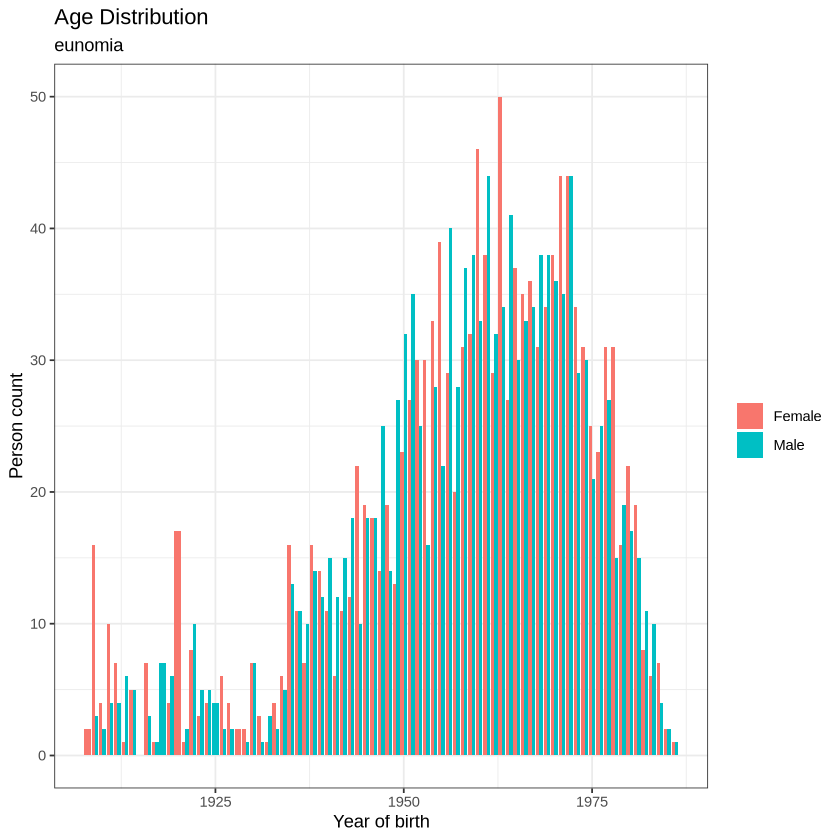

In [11]:
library(dplyr)
library(ggplot2)

cdm$person %>% 
  group_by(year_of_birth, gender_concept_id) %>% 
  summarize(n = n(), .groups = "drop") %>% 
  collect() %>% 
  mutate(sex = case_when(
    gender_concept_id == 8532 ~ "Female",
    gender_concept_id == 8507 ~ "Male"
  )) %>% 
  ggplot(aes(y = n, x = year_of_birth, fill = sex)) +
  geom_histogram(stat = "identity", position = "dodge") +
  labs(x = "Year of birth", 
       y = "Person count", 
       title = "Age Distribution",
       subtitle = cdm_name(cdm),
       fill = NULL) +
  theme_bw()

In [59]:
install.packages("RJDBC")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [60]:
#props <-  c("--add-opens java.base/java.nio=ALL-UNNAMED")
#options(java.parameters = props) 
library(RJDBC)

In [63]:
jdbc_driver_path <- "/home/jovyan/drivers/DatabricksJDBC42.jar"

drv <- JDBC(driverClass = "com.databricks.client.jdbc.Driver", classPath = jdbc_driver_path)

host <- "adb-2042419405164675.15.azuredatabricks.net"
http_path <- "sql/protocolv1/o/2042419405164675/0712-084248-iccgt930"
token <- "<insert_token_here>"

conn_string <- sprintf("jdbc:databricks://%s:443/default;transportMode=http;ssl=1;httpPath=%s;AuthMech=3;UID=token;PWD=%s;EnableArrow=0", host, http_path, token)

conn <- DBI::dbConnect(drv, conn_string)

In [64]:
tables <- dbListTables(conn)
print(tables)

  [1] "care_site"                    "cdm_source"                  
  [3] "concept"                      "concept_ancestor"            
  [5] "concept_class"                "concept_relationship"        
  [7] "concept_synonym"              "condition_era"               
  [9] "condition_occurrence"         "cost"                        
 [11] "death"                        "device_exposure"             
 [13] "domain"                       "dose_era"                    
 [15] "drug_era"                     "drug_exposure"               
 [17] "drug_strength"                "fact_relationship"           
 [19] "location"                     "measurement"                 
 [21] "metadata"                     "note"                        
 [23] "note_nlp"                     "observation"                 
 [25] "observation_period"           "payer_plan_period"           
 [27] "person"                       "procedure_occurrence"        
 [29] "provider"                     "relationsh

In [66]:
catalog <- "main"
schema <- "omop"
table <- "person"

fully_qualified_table_name <- sprintf("%s.%s.%s", catalog, schema, table)
query <- sprintf("SELECT * FROM %s LIMIT 10", fully_qualified_table_name)
result <- dbGetQuery(conn, query)

In [67]:
print(result)

   person_id gender_concept_id year_of_birth month_of_birth day_of_birth
1       4637              8507          1974              1           21
2       4117              8532          1962             12           14
3       3720              8507          1954              4            6
4       4222              8532          1949              6           16
5       4077              8507          1971              2            1
6       4811              8507          1962              4           16
7       4475              8507          1978              5           22
8       4586              8532          1956             10           28
9       4106              8532          1944              3            3
10      4333              8532          1953              8           27
   birth_datetime race_concept_id ethnicity_concept_id location_id provider_id
1      1974-01-21            8527                    0          NA          NA
2      1962-12-14            8516      